In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.set_device(0)

In [4]:
torch.backends.cudnn.benchmark=True

In [5]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/_dXqugxU1sk" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

## Data

In [6]:
PATH = Path('../data/dimview')
# MASKS_FN = 'train_masks.csv'
# META_FN = 'metadata.csv'
# masks_csv = pd.read_csv(PATH/MASKS_FN)
# meta_csv = pd.read_csv(PATH/META_FN)

In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [8]:
TRAIN_DN = 'images/train'
MASKS_DN = 'masks/train'
sz = 128
bs = 64
nw = 8

In [9]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [10]:
x_names=[]
y_names=[]
for pth in (PATH/TRAIN_DN).iterdir():
    x_names.append(TRAIN_DN + '/' + pth.name)
    y_names.append(MASKS_DN + '/' + pth.stem + '.png')
    
x_names = np.array(x_names)
y_names = np.array(y_names)

In [15]:
val_idxs = list(range(4000))
((val_x,trn_x), (val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [16]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [17]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=nw, classes=None)
denorm = md.trn_ds.denorm

In [18]:
x,y = next(iter(md.trn_dl))

In [19]:
x.shape,y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

In [20]:
f = resnet34
cut,lr_cut = model_meta[f]

In [21]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [22]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## U-net (ish)

In [23]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [24]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [25]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [26]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [27]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [28]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [29]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [30]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 64, 64]),
 torch.Size([3, 64, 32, 32]),
 torch.Size([3, 128, 16, 16]),
 torch.Size([3, 256, 8, 8])]

In [31]:
learn.freeze_to(1)

 79%|███████▉  | 446/563 [01:59<00:31,  3.74it/s, loss=0.535]

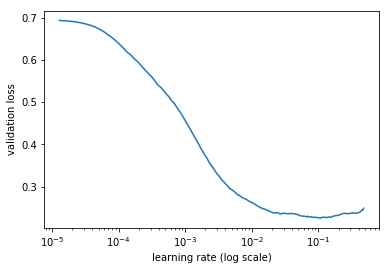

In [32]:
learn.lr_find()
learn.sched.plot()

In [33]:
lr=1e-2
# wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [34]:
learn.fit(lr,1,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.188125   0.186547   0.917817   0.740095  
    1      0.169169   0.176022   0.928835   0.780481  
    2      0.156666   0.164327   0.924346   0.770617  
    3      0.152853   0.158545   0.933323   0.794394  
    4      0.143066   0.150386   0.934081   0.797867  
    5      0.134537   0.150044   0.935797   0.802563  
    6      0.124229   0.146561   0.935554   0.803428  
    7      0.118412   0.147592   0.935714   0.803111  


[array([0.14759]), 0.9357137908935547, 0.8031109985359]

In [35]:
learn.save('128urn-tmp')

In [36]:
learn.load('128urn-tmp')

In [37]:
learn.unfreeze()
learn.bn_freeze(True)

 52%|█████▏    | 291/563 [01:21<01:15,  3.59it/s, loss=0.352]

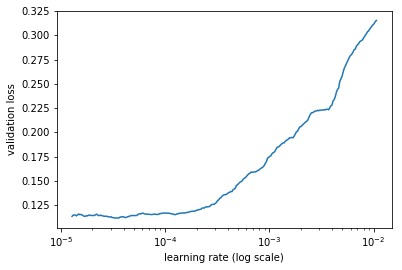

In [38]:
learn.lr_find()
learn.sched.plot()

In [39]:
lr=1e-5
# wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [40]:
learn.fit(lrs, 1, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.114449   0.146926   0.936501   0.805704  
    1      0.113183   0.146307   0.937567   0.809017  
    2      0.113302   0.14616    0.938035   0.810354  
    3      0.112891   0.146137   0.938288   0.811067  
 50%|█████     | 282/563 [01:20<01:20,  3.49it/s, loss=0.113]

KeyboardInterrupt: 

In [41]:
learn.save('128urn-0')

In [42]:
learn.load('128urn-0')

In [43]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

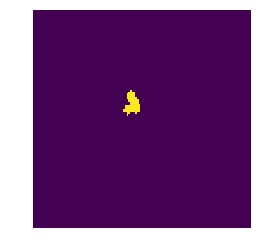

In [44]:
show_img(py[1]>0)

In [45]:
out = denorm(x)[1]

In [46]:
mask = to_np(py[1]>0).astype('float32')

In [47]:
wn_mat = np.random.uniform(0.5,1, mask.shape)

In [48]:
kernel = np.ones((5,5),np.float32)/25
wn_mat = cv2.filter2D(wn_mat,-1,kernel)[:,:,None]

In [49]:
out[np.where(mask==1)] = wn_mat[np.where(mask==1)]

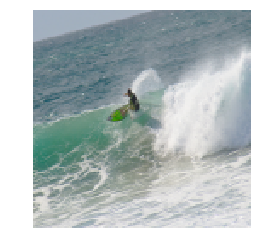

In [50]:
show_img(denorm(x)[1])

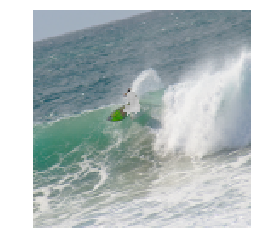

In [51]:
#ax = show_img(denorm(x)[1])
show_img(out)

In [52]:
out = denorm(x)[1]

In [53]:
mask = to_np(py[1]>0).astype('float32')

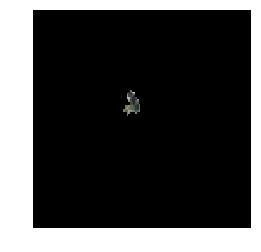

In [54]:
show_img(mask[:,:,None] * out)

In [55]:
m.close()

## 512x512

In [56]:
sz=512
bs=16

In [57]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [58]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [59]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [60]:
learn.freeze_to(1)

In [61]:
learn.load('128urn-0')

 72%|███████▏  | 1614/2250 [18:06<07:08,  1.48it/s, loss=0.448]

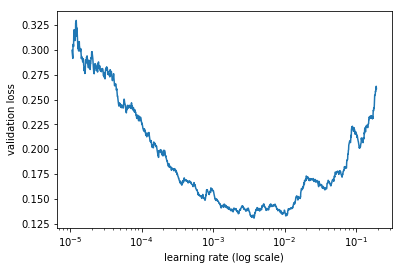

In [62]:
learn.lr_find()
learn.sched.plot()

In [63]:
lr=2e-4

In [ ]:
learn.fit(lr, 1, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.132072   0.129192   0.946305   0.838404  
    1      0.119283   0.114905   0.952242   0.856024  
    2      0.11276    0.110524   0.953202   0.860101  
 43%|████▎     | 976/2250 [10:43<14:00,  1.52it/s, loss=0.109]

In [120]:
learn.save('512urn-tmp')

In [124]:
import dill as dill
torch.save(learn.model, 'dimview.h5', pickle_module=dill)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Unet34. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type UnetBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [125]:
!mv dimview.h5 ~/export

In [139]:
learn.unfreeze()
learn.bn_freeze(True)

In [140]:
learn.load('512urn-tmp')

In [ ]:
learn.fit(lrs/4,1, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.112704   0.115849   0.952487   0.854227  
    1      0.09558    0.108637   0.955537   0.86495   
    2      0.102618   0.112072   0.953808   0.859186  
    3      0.088634   0.102895   0.958914   0.871264  
 19%|█▉        | 230/1188 [02:31<10:31,  1.52it/s, loss=0.0881]

In [52]:
learn.save('512urn')

In [26]:
learn.load('512urn')

In [75]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

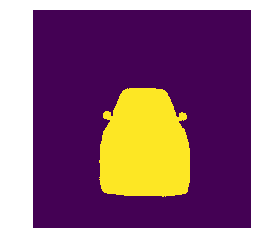

In [76]:
show_img(py[0]>0);

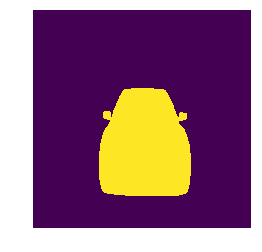

In [77]:
show_img(y[0]);

In [78]:
m.close()

## 1024x1024

In [26]:
sz=1024
bs=4

In [27]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [28]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [29]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [30]:
learn.load('512urn')

In [31]:
learn.freeze_to(1)

In [32]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.007656   0.008155   0.997247   0.99353   
    1      0.004706   0.00509    0.998039   0.995437             



[0.005090427414942828, 0.9980387706605215, 0.995437301104031]

In [33]:
learn.save('1024urn-tmp')

In [30]:
learn.load('1024urn-tmp')

In [31]:
learn.unfreeze()
learn.bn_freeze(True)

In [32]:
lrs = np.array([lr/200,lr/30,lr])

In [33]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.005688   0.006135   0.997616   0.994616  
    1      0.004412   0.005223   0.997983   0.995349             
    2      0.004186   0.004975   0.99806    0.99554              
    3      0.004016   0.004899   0.99812    0.995627             



[0.004898778487196458, 0.9981196409180051, 0.9956271404784823]

In [33]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.004169   0.004962   0.998049   0.995517  
    1      0.004022   0.004595   0.99823    0.995818             
    2      0.003772   0.004497   0.998215   0.995916             
    3      0.003618   0.004435   0.998291   0.995991             



[0.004434524739663753, 0.9982911745707194, 0.9959913929776539]

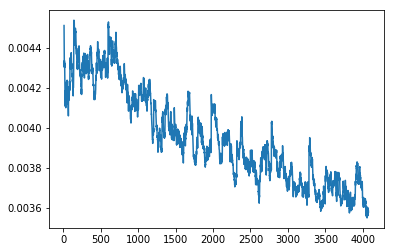

In [34]:
learn.sched.plot_loss()

In [35]:
learn.save('1024urn')

In [26]:
learn.load('1024urn')

In [36]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

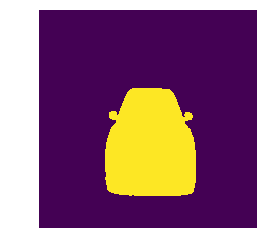

In [37]:
show_img(py[0]>0);

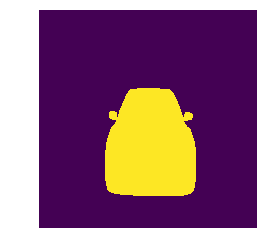

In [38]:
show_img(y[0]);